# Section 2.7 — Random variable generation

This notebook contains the code examples from [Section 2.7 Random variable generation]() of the **No Bullshit Guide to Statistics**.



#### Notebook setup

In [1]:
# load Python modules
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Figures setup
sns.set_theme(
    context="paper",
    style="whitegrid",
    palette="colorblind",
    rc={'figure.figsize': (7,4)},
)

%config InlineBackend.figure_format = 'retina'

# # silence annoying warnings
# import warnings; warnings.filterwarnings('ignore')

In [3]:
# set random seed for repeatability
random.seed(42)
np.random.seed(42)

## Why simulate?

Running simulations of random variables is super useful:

- fake data generation
- prob
- stats

(see book)


## Random variable generation using a computer

In [55]:
import random

random.random()

0.5239625430006316

In [5]:
# # ALT.
# import numpy as np
# np.random.rand()

### Discrete random variable generation


#### Example 1: generating Bernoulli observations

Consider the Bernoulli random variable $B \sim \textrm{Bernoulli}(p)$,
which corresponds to a coin toss with probability of heads (outcome 1) equal to $p$,
and probability of tails (outcome 0) $(1-p)$.

The function `gen_b` defined below is a generator of observations from the random variable $B$.

In [6]:
def gen_b(p=0.5):
    u = random.random()
    if u < p:
        return 1
    else:
        return 0

To generate a random observation from $B \sim \textrm{Bernoulli}(p=0.3)$,
we simply need to call the function `gen_b` with the keyword argument `p=0.3`.

In [7]:
gen_b(p=0.3)

1

Let's now generates `n=1000` observations from $B \sim \textrm{Bernoulli}(p=0.3)$,
and compute the proportion of the outcome $1$ (heads) in the list.

In [8]:
n = 1000
bsample = [gen_b(p=0.3) for i in range(0,n)]
bsample.count(1) / n

0.295

### Continuous random variable generation (optional)

#### Example 2: generating observations from a shifted uniform distribution



$V \sim \mathcal{U}(\alpha=100,\beta=120)$




In [9]:
def gen_v():
    u = random.random()
    v = 100 + 20*u
    return v


In [10]:
gen_v()

110.8893172296429

In [11]:
n = 100
vsample = [gen_v() for i in range(0,n)]
min(vsample), max(vsample)

(100.05671102960032, 119.89255511721848)

<AxesSubplot:ylabel='Density'>

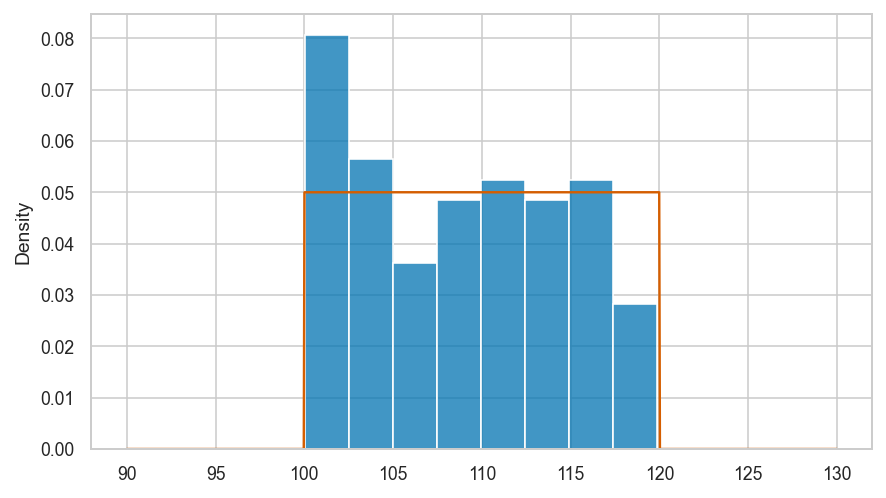

In [43]:
# plot a histogram of the data we generated
sns.histplot(vsample, stat="density")

# plot the pdf of rvV on the same axes
from scipy.stats import uniform
xs = np.linspace(90,130,1000)
sns.lineplot(x=xs, y=uniform(100,20).pdf(xs), color="r")

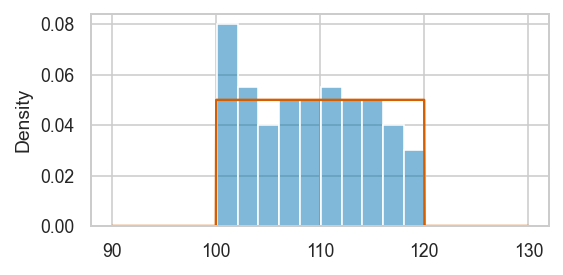

In [42]:
filename = "figures/prob/generate_vsample_and_pdf_rvV.pdf"
from scipy.stats import uniform
with plt.rc_context({"figure.figsize":(4,2)}):
    ax = sns.histplot(vsample, stat="density", alpha=0.5, binwidth=2)
    xs = np.linspace(90,130,1000)
    sns.lineplot(x=xs, y=uniform(100,20).pdf(xs), ax=ax, color="r")
    ax.figure.tight_layout()
    ax.figure.savefig(filename, dpi=300, bbox_inches="tight", pad_inches=0.02)

#### Example 3: generating observations from an exponential distribution

In [13]:
def gen_e(lam):
    u = random.random()
    e = -1 * np.log(1-u) / lam
    return e

Where `lam` is the $\lambda$ (lambda) parameter chosen for exponential model family.

In [14]:
np.random.seed(6)

n = 100    # number of observations to generate
esample = [gen_e(lam=0.2) for i in range(0,n)]
esample[0:5]

[5.473208708707206,
 6.937160045009132,
 10.128258488361,
 6.383805036798691,
 17.272773282670244]

In [15]:
# compare with samples from the theoretical density function
from scipy.stats import expon
lam = 0.2
rvE = expon(0,1/lam)
rvE.rvs(5)

array([11.16810151,  2.01718437,  8.60825155,  0.21295438,  0.56952166])

<AxesSubplot:ylabel='Density'>

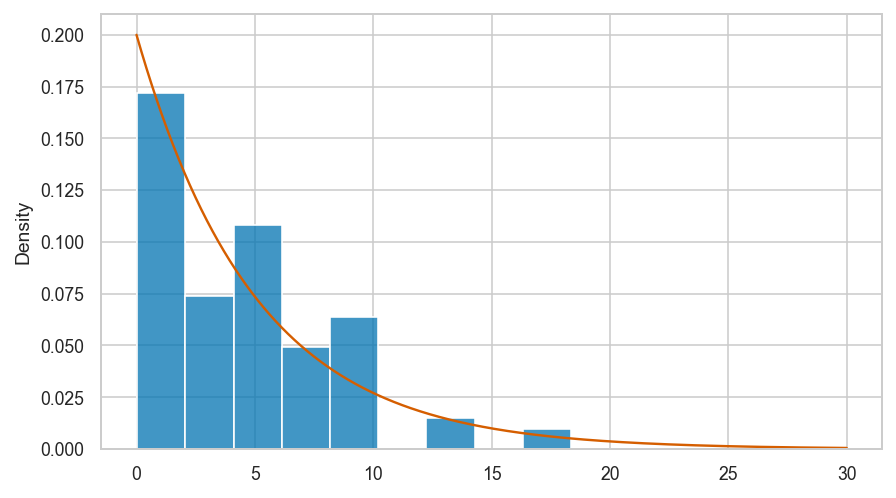

In [16]:
# plot a histogram of the data we generated
sns.histplot(esample, stat="density")

# plot the pdf of rvE on the same axes
xs = np.linspace(0,30,1000)
sns.lineplot(x=xs, y=rvE.pdf(xs), color="r")

In [17]:
# filename = "figures/prob/generate_exp_and_pdf_rvE.pdf"
# with plt.rc_context({"figure.figsize":(4,2)}):
#     ax = sns.histplot(esample, stat="density", alpha=0.5)
#     es = np.linspace(0,30,1000)
#     sns.lineplot(x=xs, y=rvE.pdf(es), ax=ax, color="r")
#     ax.set_xlim([0,30])
#     ax.figure.tight_layout()
#     ax.figure.savefig(filename, dpi=300, bbox_inches="tight", pad_inches=0.02)

We'll develop various way to analyze this "goodness of fit" between the sample `esample` data we generated
and the theoretical model $f_E$ in the remainder of this notebook.

## Empirical distributions

Let's write a function that compute the value empirical cumulative distribution (eCDF) 
of the sample `data`. The function takes two inputs:
- `data`: the sample of observations
- `b`: the value where we want to evaluate the function


In [44]:
def ecdf(data, b):
    sdata = np.sort(data)
    count = sum(sdata <= b)    # counts num. of obs. <= b
    return count / len(data)   # proportion of total

Note the sorting step is not strictly necessary,
but it ...


In [19]:
ecdf(vsample, 110)

0.55

<AxesSubplot:>

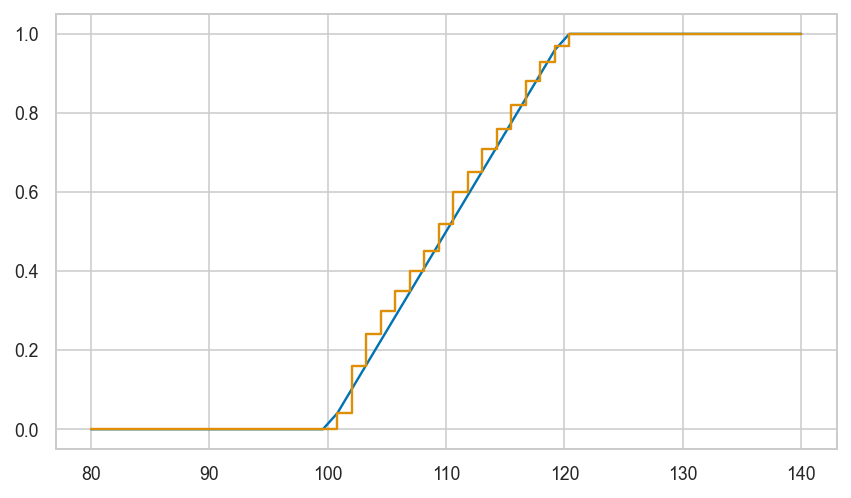

In [20]:
from scipy.stats import uniform
rvV = uniform(100,20)

bs = np.linspace(80,140)
sns.lineplot(x=bs, y=rvV.cdf(bs))

empFvs = [ecdf(vsample,b) for b in bs]
sns.lineplot(x=bs, y=empFvs, drawstyle='steps-post')

<AxesSubplot:>

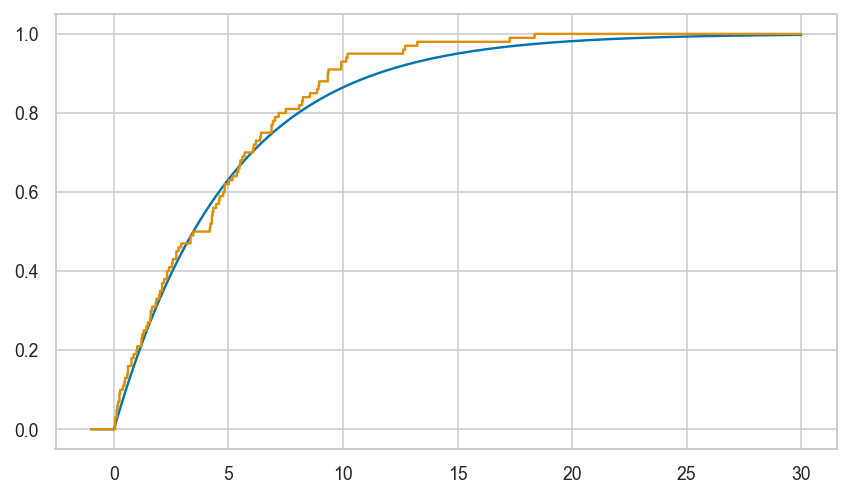

In [21]:
bs = np.linspace(-1,30,1000)
sns.lineplot(x=bs, y=rvE.cdf(bs))

empFes = [ecdf(esample,b) for b in bs]
sns.lineplot(x=bs, y=empFes, drawstyle='steps-post')

<AxesSubplot:>

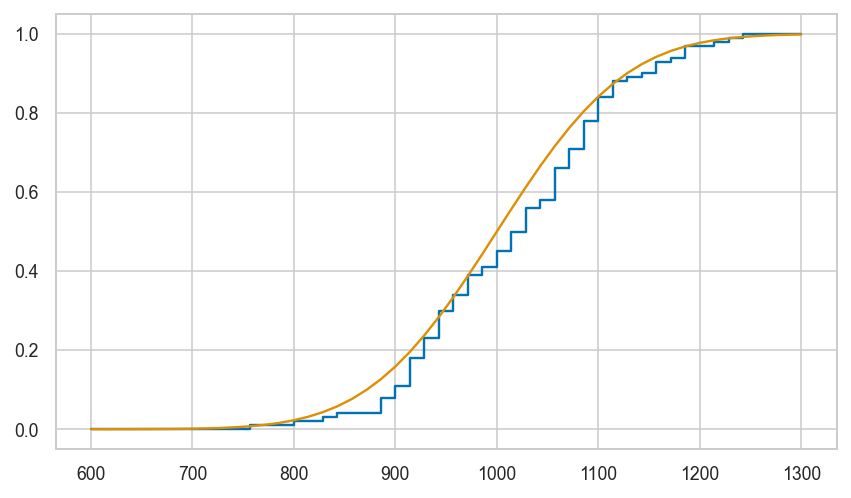

In [22]:
# Bonus: try playing with parameter n
from scipy.stats import norm
rvN = norm(1000,100)

n = 100  # CHANGE ME: what is eCDF when n=10? ; when n=1000?
ndata = rvN.rvs(n)
bs = np.linspace(600,1300)
empFbs = [ecdf(ndata,b) for b in bs]
sns.lineplot(x=bs, y=empFbs, drawstyle='steps-post')

sns.lineplot(x=bs, y=rvN.cdf(bs))

In [23]:
# # ALT: use the `ECDF` function generator from statsmodels
# import statsmodels.api as sm
# ecdf3 = sm.distributions.ECDF(ndata)
# xs3 = np.linspace(600,1300)
# ys3 = ecdf3(xs3)
# sns.lineplot(x=xs3, y=ys3, drawstyle='steps-post')
# sns.lineplot(x=xs3, y=rvN.cdf(xs3))

## Measuring data-model fit

Want to measure if `vsample` comes from $\mathcal{U}(100,120)$.
Here are the first five values we simulated:

In [24]:
vsample[0:5]

[119.55685058904093,
 107.17347682424636,
 107.96279285488747,
 103.7961712432216,
 102.44319438174527]

We also want to check if the data we generated `esample` comes from $\textrm{Expon}(\lambda=0.2)$.

In [25]:
esample[0:5]

[5.473208708707206,
 6.937160045009132,
 10.128258488361,
 6.383805036798691,
 17.272773282670244]

Let's also generate some additional samples from different distributions,
so we'll be able to make a variety of comparisons:

- `usample`: a sample of 1000 observations from the standard uniform $\mathcal{U}(0,1)$
- `nsample`: a sample of 1000 observations from normal distribution $\mathcal{N}(1000,100)$

In [26]:
from scipy.stats import uniform
usample = uniform(0,1).rvs(1000)       # ~ U(0,1)

from scipy.stats import norm
nsample = norm(1000, 100).rvs(1000)    # ~ N(1000, 100)

### Visual comparison between data and model distributions

#### Shifted uniform distribution

Here is the code for comparison of `vsample` and the theoretical model `rvV` $= \mathcal{U}(100,120)$.

In [27]:
from scipy.stats import uniform
rvV = uniform(100,20)

<AxesSubplot:ylabel='Density'>

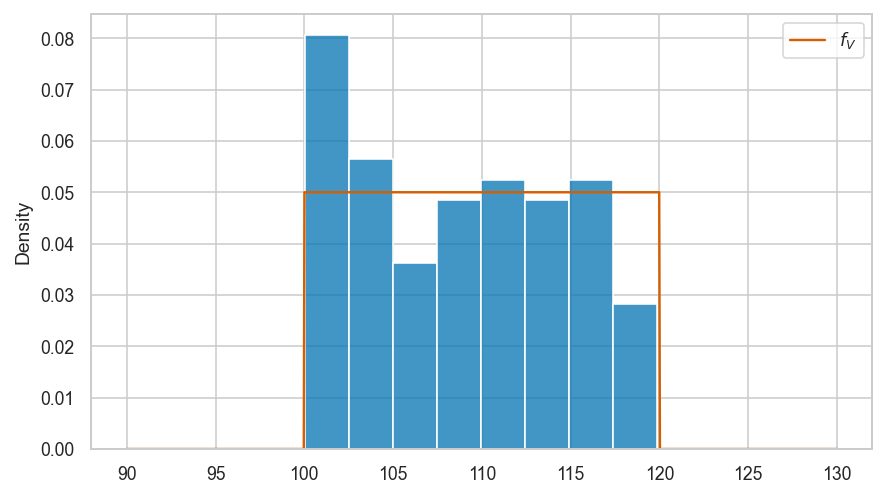

In [28]:
# plot histogram of `vsample` on the same axes
sns.histplot(vsample, stat="density")

# plot the pdf of rvV 
xs = np.linspace(90,130,1000)
sns.lineplot(x=xs, y=rvV.pdf(xs), color="r", label="$f_V$")

<AxesSubplot:>

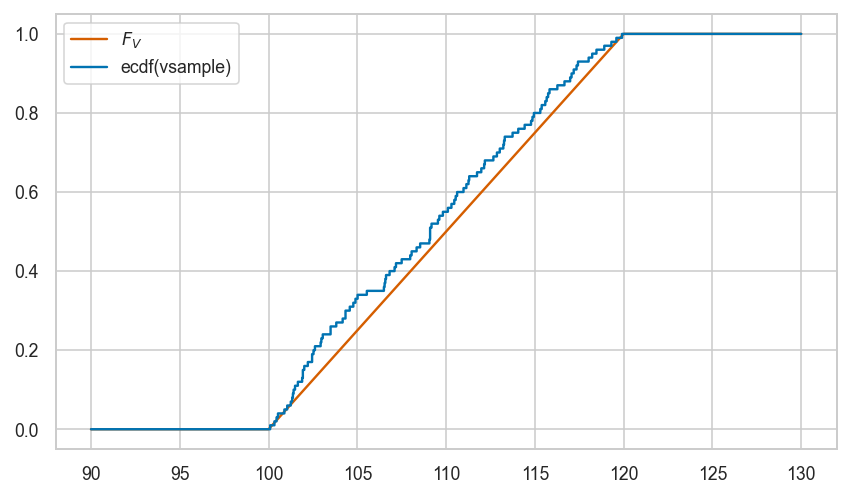

In [29]:
# plot the CDF of rvV on the same axes
bs = np.linspace(90,130,1000)
sns.lineplot(x=bs, y=rvV.cdf(bs), color="r", label="$F_V$")

# plot a empirical cumulative distribution
empFbs = [ecdf(vsample,b) for b in bs]
sns.lineplot(x=bs, y=empFbs, drawstyle='steps-post', label="ecdf(vsample)")

#### Exponential distribution

In [30]:
from scipy.stats import expon
lam = 0.2
rvE = expon(0,1/lam)

Here is the code for comparison of `esample` and the theoretical model `rvE` $=\mathrm{Expon}(\lambda=0.2)$.

<AxesSubplot:ylabel='Density'>

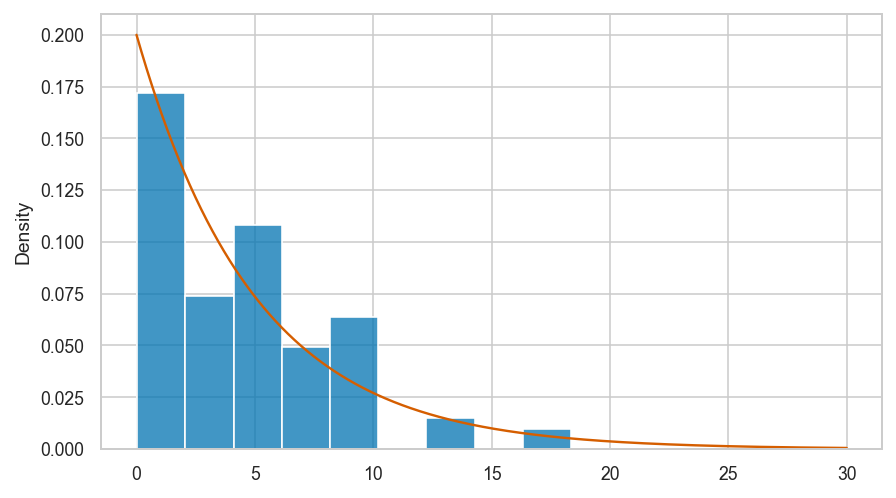

In [31]:
# plot a histogram of the data we generated
ax = sns.histplot(esample, stat="density")

# plot the pdf of rvE on the same axes
xs = np.linspace(0,30,1000)
sns.lineplot(x=xs, y=rvE.pdf(xs), ax=ax, color="r")

<AxesSubplot:>

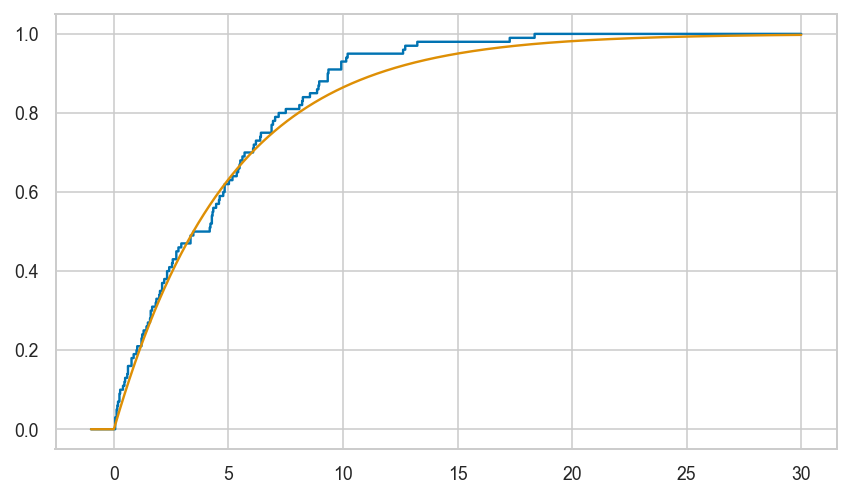

In [32]:
# plot the empirical distribution of `esamples`
bs = np.linspace(-1,30,1000)
empFes = [ecdf(esample,b) for b in bs]
sns.lineplot(x=bs, y=empFes, drawstyle='steps-post')

# plot the CDF of rvE
sns.lineplot(x=bs, y=rvE.cdf(bs))

### Using Q-Q plots to compare quantiles

The quantile-quantile plot `qqplot(data, dist)`
is used to compare the positions of the quantiles of the dataset `data`
against the quantiles of the theoretical distribution `dist`,
which is an instance of one of the probability models in `scipy.stats`.

The easiest way to generate a Q-Q plot is to use
the function `qqplot` defined in the the `statsmodels` package.

In [33]:
from statsmodels.graphics.api import qqplot

# see examples below

#### Examples of good fit


##### Normal data vs. the true normal model

Let's look at the quantiles of the data in `nsample`,
plotted versus the quantiles of the theoretical model $\mathcal{N}(1000,100)$.

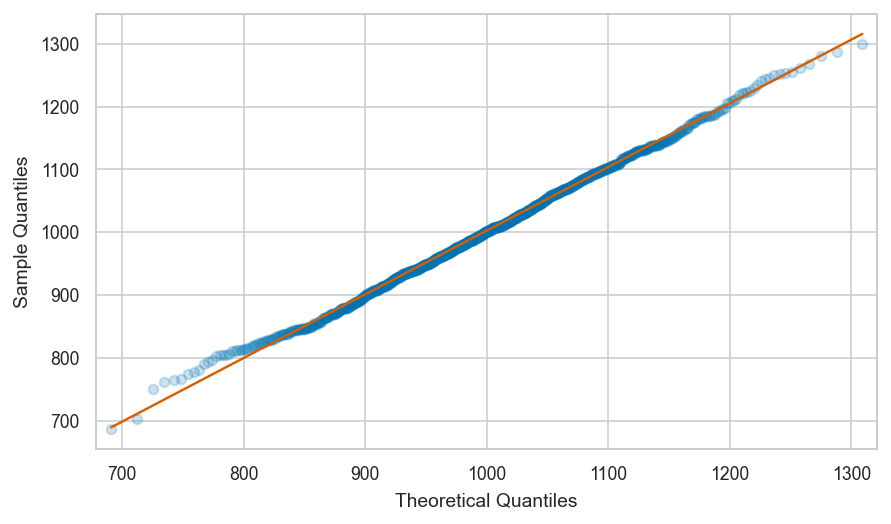

In [34]:
_ = qqplot(nsample, dist=norm(1000,100), line='q', alpha=0.2)

In [35]:
# filename = "figures/prob/qqplot_ndata_vs_norm1000_100.pdf"
# with plt.rc_context({"figure.figsize":(4,3)}):
#     fig = qqplot(nsample, dist=norm(1000,100), line='q', markersize=1, alpha=0.2)
#     fig.tight_layout()
#     fig.savefig(filename, dpi=300, bbox_inches="tight", pad_inches=0.02)

#### Normal data vs. the standard normal

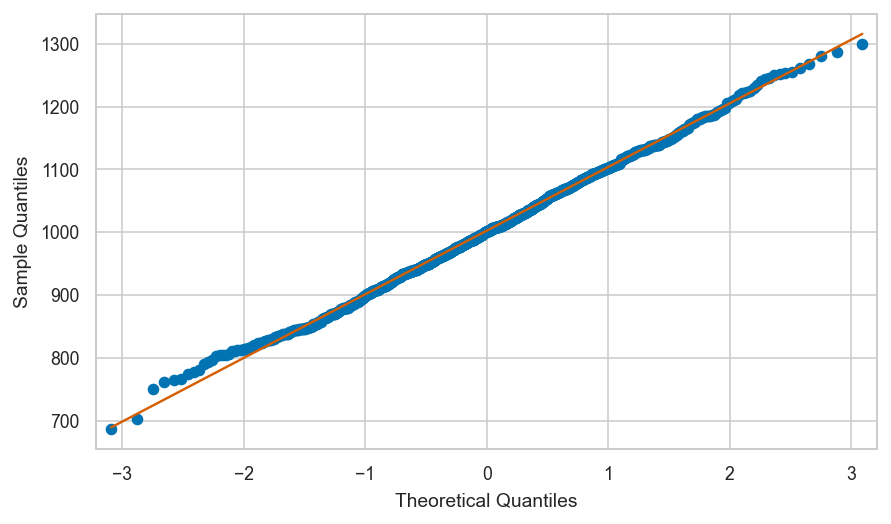

In [36]:
_ = qqplot(nsample, dist=norm(0,1), line='q')

In [37]:
# filename = "figures/prob/qqplot_ndata_vs_stdnorm.pdf"
# with plt.rc_context({"figure.figsize":(4,3)}):
#     fig = qqplot(nsample, dist=norm(0,1), line='q', markersize=1)
#     fig.tight_layout()
#     fig.savefig(filename, dpi=300, bbox_inches="tight", pad_inches=0.02)

#### Examples of bad fit

##### Exponential data vs. standard normal

In [38]:
_ = qqplot(esample, dist=norm(0,1), line="q")

AttributeError: 'list' object has no attribute 'shape'

Note the lowest quantiles of the 

In [ ]:
# filename = "figures/prob/qqplot_edata_vs_stdnorm.pdf"
# with plt.rc_context({"figure.figsize":(4,3)}):
#     fig = qqplot(esample, dist=norm(0,1), line='q', markersize=1)
#     fig.tight_layout()
#     fig.savefig(filename, dpi=300, bbox_inches="tight", pad_inches=0.02)

##### Uniform data vs. standard normal

In [ ]:
_ = qqplot(usample, dist=norm(0,1), line="q")

In [ ]:
# filename = "figures/prob/qqplot_udata_vs_stdnorm.pdf"
# with plt.rc_context({"figure.figsize":(4,3)}):
#     fig = qqplot(usample, dist=norm(0,1), line='q', markersize=1)
#     fig.tight_layout()
#     fig.savefig(filename, dpi=300, bbox_inches="tight", pad_inches=0.02)

#### Exponential data vs. true exponential model

In [ ]:
from scipy.stats import expon

_ = qqplot(esample, dist=expon(0,1/0.2), line="q")

In [ ]:
# filename = "figures/prob/qqplot_edata_vs_rvE.pdf"
# with plt.rc_context({"figure.figsize":(4,3)}):
#     fig = qqplot(esample, dist=rvE, line='q', markersize=1)
#     fig.tight_layout()
#     fig.savefig(filename, dpi=300, bbox_inches="tight", pad_inches=0.02)

#### Generating a Q-Q plot manually (optional reading)

If want to know how the Q-Q plot is generated,
you can look at the following function `qq_plot` which the same way as `qqplot`.

In [ ]:
def qq_plot(data, dist, line="q"):
    qs = np.linspace(0, 1, len(data))
    xs = dist.ppf(qs)
    ys = np.quantile(data, qs)
    ax = sns.scatterplot(x=xs, y=ys, alpha=0.2)
    if line == "q":
        # compute the parameters m and b for the diagonal
        xq25, xq75 = dist.ppf([0.25, 0.75])
        yq25, yq75 = np.quantile(data, [0.25,0.75])
        m = (yq75-yq25)/(xq75-xq25)
        b = yq25 - m * xq25
        # add the line  y = m*x+b  to the plot
        linexs = np.linspace(min(xs[1:]),max(xs[:-1]))
        lineys = m*linexs + b
        sns.lineplot(x=linexs, y=lineys, ax=ax, color="r")
    return ax

In [ ]:
# # ALT. use the `probplot` from the `scipy.stats` module
# from scipy.stats import probplot
# _ = probplot(nsample, dist=norm(1000,100), plot=plt)

### Comparing moments

A simple way to measure how well the data sample $\mathbf{x} = (x_1, x_2, \ldots , x_n)$
fits the probability model $f_X$ is to check if the data distribution  and the probability distribution have the same moments.


In [ ]:
# convert `esample` to a Pandas series
eseries = pd.Series(esample)

In [ ]:
eseries.mean(), rvE.mean()

In [ ]:
eseries.var(), rvE.var()

The [skew](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.skew.html) of dataset and the skew of the distribution:

In [ ]:
eseries.skew(), rvE.stats("s")

The [kurtosis](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.kurt.html) of dataset and the kurtosis of the distribution.

In [ ]:
eseries.kurt(), rvE.stats("k")

### Kolmogorov–Smirnov test

In [ ]:
from scipy.stats import ks_1samp

#### Example 3 (continued): KS distance of `esample` to reference

In [ ]:
from scipy.stats import expon
lam = 0.2
rvE = expon(0,1/lam)

ks_1samp(esample, rvE.cdf).statistic

In [ ]:
xs = np.linspace(0,35,1000)
fEs = rvE.pdf(xs)
ax = sns.histplot(esample, stat="density")
sns.lineplot(x=xs, y=fEs, ax=ax, color="r")

#### Example 5: KS distance of `nsample` to reference normal

In [ ]:
ks_1samp(nsample, rvN.cdf).statistic

In [ ]:
ax = sns.histplot(nsample, stat="density")
xs = np.linspace(600,1400,1000)
fNs = rvN.pdf(xs)
sns.lineplot(x=xs, y=fNs, ax=ax, color="r")

#### KS distance after normalization (optional reading)

Define the function `standardize` that transforms any dataset
so it will have mean zero, and standard deviation one.

In [ ]:
def standardize(data):
    xbar = data.mean()
    s = data.std()
    return (data-xbar)/s

We can now report the KS distances,
between the standardized version so `nsample`, `esample`, and `usample` and
standard normal $f_Z$,
to check how "normal" they are.


In [ ]:
nsample_std = standardize(nsample)
ks_1samp(nsample_std, norm(0,1).cdf).statistic

In [ ]:
esample_std = standardize(esample)
ks_1samp(esample_std, norm(0,1).cdf).statistic

In [ ]:
usample_std = standardize(usample)
ks_1samp(usample_std, norm(0,1).cdf).statistic

### Calculating the KS distance manually (optional)

In [ ]:
from scipy.stats import norm

def ks_dist(sample, rv=norm(0,1)):
    """
    Compute the KS distance between observed data in `sample`
    and the theoretical distribution of random variable `rv`.
    """
    sample = sorted(sample)
    ks_dists = []

    x0 = sample[0]
    ks_dist0 = rv.cdf(x0)
    ks_dists.append(ks_dist0)

    n = len(sample)
    for i in range(1,n):
        # xi
        xi = sample[i]
        eCDFxi = ecdf(sample, b=xi)
        ks_dist1 = abs(eCDFxi - rv.cdf(xi))
        ks_dists.append(ks_dist1)
        # x(i-1)
        xim1 = sample[i-1]
        eCDFxim1 = ecdf(sample, b=xim1)
        ks_dist2 = abs(eCDFxim1 - rv.cdf(xi))
        ks_dists.append(ks_dist2)

    # find max
    max_ks_dist = max(ks_dists)
    return max_ks_dist

#### Test 1

In [ ]:
ks_dist(nsample, rv=norm(1000,100))

In [ ]:
ks_1samp(nsample, norm(1000,100).cdf).statistic

#### Test 2

In [ ]:
ks_dist(standardize(nsample), rv=norm(0,1))

In [ ]:
ks_1samp(standardize(nsample), norm(0,1).cdf).statistic

## Bootstrap sample generation

In [ ]:
from scipy.stats import norm
rvN = norm(1000, 100)

nsample = rvN.rvs(30)
nsample

In [ ]:
nsample.mean()

Let's generate a bootstrap sample and compute its mean:

In [ ]:
bsample = np.random.choice(nsample, 30)
bsample.mean()

Let's compute the means of $10$ bootstrap samples:

In [ ]:
B = 10
bmeans = []
for k in range(0,B):
    bsample = np.random.choice(nsample, 30)
    bmean = bsample.mean() 
    bmeans.append(bmean)

# bmeans

In [ ]:
print([round(bmean, 2) for bmean in bmeans])

In [ ]:
max(abs(bmeans - nsample.mean()))

In [ ]:
# # Numbers used in the book
# mean_book = 1015.88
# bmeans_book = np.array(
#     [ 1036.75,  975.73, 1011.78, 1009.29, 1015.71,
#        979.29, 1001.40, 1009.50, 1028.11, 1039.63])
# max(abs(bmeans_book - mean_book))

In [ ]:
# # BONUS: draw B=1000 bootstrap samples ot obtain a full histogram
# B = 1000
# bmeans = []
# for i in range(0,B):
#     bsample = np.random.choice(nsample, 30)
#     bmean = bsample.mean() 
#     bmeans.append(bmean)

# ax = sns.histplot(bmeans, stat="density")
# ax.set_xlim(600,1400)

#### Clarification: empirical distribution of `nsample` is not the same as $f_N$

In [ ]:
# plot the pmf of uknown distritbuon f_N
from scipy.stats import norm
rvN = norm(1000, 100)
xs = np.linspace(600,1400)
ax = sns.lineplot(x=xs, y=rvN.pdf(xs))

# generate histogram from a single samples of size 30
n = 30  # sample size
nsample = rvN.rvs(n)
sns.histplot(nsample, binwidth=25, stat="density", ax=ax)
ax.set_xlim(600,1400)

In [ ]:
# TODO: stem plot of sample
# TODO: stem plot alpha=0.1 of bsamples

In [ ]:
# filename = "figures/prob/bootstrap_sample_from_norm1000_100.pdf"
# with plt.rc_context({"figure.figsize":(5,3)}):
#     ax = sns.lineplot(x=xs, y=rvN.pdf(xs)*25*n)
#     sns.histplot(bsamples, binwidth=25, ax=ax)
#     ax.set_xlim(600,1400)
#     ax.figure.tight_layout()
#     ax.figure.savefig(filename, dpi=300, bbox_inches="tight", pad_inches=0.02)

## Discussion